In [143]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from pprint import pprint
import json
from tqdm import tqdm
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import re

df = pd.read_pickle('data/cdis_with_schemas.pkl')

In [14]:
df.head()

,medium_description_en,url,full_title_en,expert_name,short_title_en,short_description_en,disease_en,system_en,search_abbreviation_en,purpose_en,...,input_schema,content,cmeReleaseDate,dosing,seo,md5,related_calcs,created_at,updated_at,num_rules
0,Diagnoses delirium in older patients.,4-test-delirium-assessment,4 A’s Test for Delirium Screening,[],4AT,Delirium screening.,"['Delirium', 'Dementia']","['Neurologic', 'Psychiatric']","['4at', ""4 A's Test"", '4as test', 'delirium sc...",Diagnosis,...,"[{'optional': False, 'default': 0, 'show_point...","{'reviewer': {'expert_name': []}, 'related_res...",None,False,{'meta_description_en': 'The 4 A’s Test for De...,24ae261c87f41784ca0beae2147dda0a,"[{'calcId': 3995, 'short_title_en': 'AMT-4', '...",NaN,NaN,4.0
1,Rules out PE based on clinical criteria.,4-level-pulmonary-embolism-clinical-probabilit...,4-Level Pulmonary Embolism Clinical Probabilit...,[],4PEPS Score for PE,Rules out PE.,"['Deep Venous Thrombosis', 'Pulmonary Embolism']","['Cardiac', 'Respiratory']",4-Level Pulmonary Embolism Clinical Probabilit...,"['Diagnosis', 'Rule Out']",...,"[{'label_en': 'Age', 'conditionality': '', 'de...",{'how_to_use': {'use_case_en': '<p>Do you use ...,None,False,{'meta_description_en': 'The 4-Level Pulmonary...,,"[{'calcId': 1750, 'short_title_en': 'Geneva Sc...",NaN,NaN,12.0
2,Predicts in-hospital mortality in patients adm...,4c-mortality-score-covid-19,4C Mortality Score for COVID-19,"['Miguel Reyes, MD ', 'Arsalan Shawl, DO']",4C Mortality Score for COVID-19,In-hospital COVID-19 mortality.,"['COVID-19', 'Coronavirus']",Respiratory,"4C Mortality Score for COVID-19, 4C, 4C mortal...",Prognosis,...,"[{'type': 'radio', 'label_en': 'Age, years ', ...",{'how_to_use': {'use_case_en': '<p>Apply to ri...,None,False,{'meta_description_en': 'The 4C Mortality Scor...,,"[{'calcId': 10279, 'short_title_en': 'MuLBSTA ...",NaN,NaN,10.0
3,Differentiates patients with HIT from those wi...,4ts-score-heparin-induced-thrombocytopenia,4Ts Score for Heparin-Induced Thrombocytopenia,"Calvin Hwang, MD",4Ts for HIT,HIT vs other causes of thrombocytopenia.,"['Bleeding/Hemorrhage', 'Thrombocytopenia']",Hematologic,"['plt', 'HIT']",Diagnosis,...,"[{'default': 2, 'label_en': 'Thrombocytopenia'...","{'about': {'evidence_based_medicine_en': '', '...",NaN,False,{'meta_description_en': 'The 4Ts Score is a cl...,0483d560043c355df74af2ff2c3337b7,"[{'calcId': 1789, 'short_title_en': 'HIT Exper...",NaN,NaN,4.0
4,Calculates reference values for distance walke...,6-minute-walk-distance,6 Minute Walk Distance,[],6 Minute Walk Distance,Functional status.,"['CHF', 'Chronic Pain', 'Congestive Heart Fail...",Any/All,"['6MWD', 'walking', 'six minute', 'functional ...",Formula,...,"[{'type': 'toggle', 'label_en': 'Sex', 'name':...","{'how_to_use': {'use_case_en': '', 'pearls_pit...",NaN,False,{'meta_description_en': 'The 6 Minute Walk Dis...,9e1022e778dabfcc554ce1042961b6b2,"[{'calcId': 10161, 'short_title_en': 'COPD Ass...",NaN,NaN,5.0


In [37]:
schema = df['input_schema'].iloc[0]

In [38]:
schema

[{'optional': False,
  'default': 0,
  'show_points': True,
  'conditionality': '',
  'name': 'alert',
  'tips_en': 'May ask patient to state name and address to help with rating',
  'label_en': '<p>Alertness</p>',
  'type': 'radio',
  'options': [{'label': 'Normal', 'value': 0},
   {'label': 'Mild sleepiness for <10 seconds after waking, then normal',
    'value': 0},
   {'label': 'Clearly abnormal', 'value': 4}]},
 {'optional': False,
  'default': 0,
  'show_points': True,
  'conditionality': '',
  'name': 'amt',
  'tips_en': 'Age, date of birth, place (name of the hospital or building), current year',
  'label_en': '<p><calculator id="3995">AMT 4</calculator></p>',
  'type': 'radio',
  'options': [{'label': 'No mistakes', 'value': 0},
   {'label': '1 mistake', 'value': 1},
   {'label': '≥2 mistakes or untestable', 'value': 2}]},
 {'optional': False,
  'default': 0,
  'show_points': True,
  'conditionality': '',
  'name': 'atte',
  'tips_en': 'Instruct patient to list months in rever

In [25]:
for s in schema:
    print(s['name'], s['label_en'])

alert <p>Alertness</p>
amt <p><calculator id="3995">AMT 4</calculator></p>
atte <p>Attention</p>
acute <p>Acute change or fluctuating course</p>


In [79]:
def get_label_ens(schema):
    # print('1', schema)
    # schema = schema[0]
    # pprint(schema)
    if isinstance(schema, list):
        # for s in schema:
        #     print(s.keys())
        return [s['label_en'] if 'label_en' in s else 'unknown'
                for s in schema]
    else:
        return []

In [207]:
def filter_words(all_words):
    ans = []
    for word in all_words:
        word = re.sub(CLEANR, '', word)
        word = word.replace(', mmHg', '')

        # not done perfectly
        keywords = ['Age', 'ASA', 'Albumin', 'ED visits', 'EKG', 'ESR', 'Endoscopy', 'BMI', 'BUN', 'Biliary', 'Bilirubin', 'Blood in stool', 'Congestive heart failure', 'Creatinine', 'D-dimer', 'Dementia', 'Diastolic BP', 'Distracting ', 'ECOG', 'Glucose', 'Hematocrit', 'Hemoglobin', 'Pulse', 'Respiratory rate', 'Scalp hematoma', 'Systolic BP']
        for keyword in keywords:
            if word.startswith(keyword):
                word = keyword

        keywords_contain = ['BMI']
        for keyword in keywords_contain:
            if keyword in word:
                word = keyword
                # word = word.replace('Age, years', 'Age')

        keywords_map = {'Systolic Blood Pressure': 'Systolic BP'}
        for keyword in keywords_map.keys():
            if word.lower().startswith(keyword.lower()):
                word = keywords_map[keyword]
        ans.append(word)
    return list(set(ans))

df['label_ens_list'] = df['input_schema'].apply(get_label_ens)
words = df['label_ens_list'].apply(filter_words)
all_words = sum(words, []) # concatenate all list
CLEANR = re.compile('<.*?>')



all_words = pd.Series(all_words)
all_words = all_words[~(all_words=='unknown')]
counts = all_words.value_counts()

In [208]:
feat_names = pd.Series(counts.index).apply(lambda x: x[:39])
for feat_name in sorted(feat_names):
    print(feat_name)
# print(sorted(feat_names))


 >1 extranodal site
 Age at diagnosis, years (A)
 HLA match group
 Hemophagocytosis features on bone marr
 Motor response
 Pupil response
% alcohol
% bands
% basophils
% myeloblasts in peripheral blood
% neutrophils
% of reticulocytes
&ge;2 sites of metastasis
&gt;3 hrs from symptom onset (or last t
0.45% saline
0.9% saline
1. Anxious mood: Worries, anticipation 
1. Felt low in spirits or sad?
1. I have been less alert.
1. Sleep onset insomnia:
10 . Respiratory symptoms: Pressure or 
10. Concentration/decision making:
10. Dysarthria
10. I have had trouble maintaining phys
100 mEq NaHCO₃ in 1L D5W
10: Dysarthria
10a. Suffered from reduced appetite?
10b. Suffered from increased appetite?
11. Extinction and inattention
11. Gastrointestinal symptoms: Difficul
11. I have had difficulty making decisi
11. Outlook (self):
11: Extinction/inattention
11: Test extinction/inattention/neglect
12. Genitourinary symptoms: Frequency o
12. I have been less motivated to do an
12. Suicidal ideation:
13.

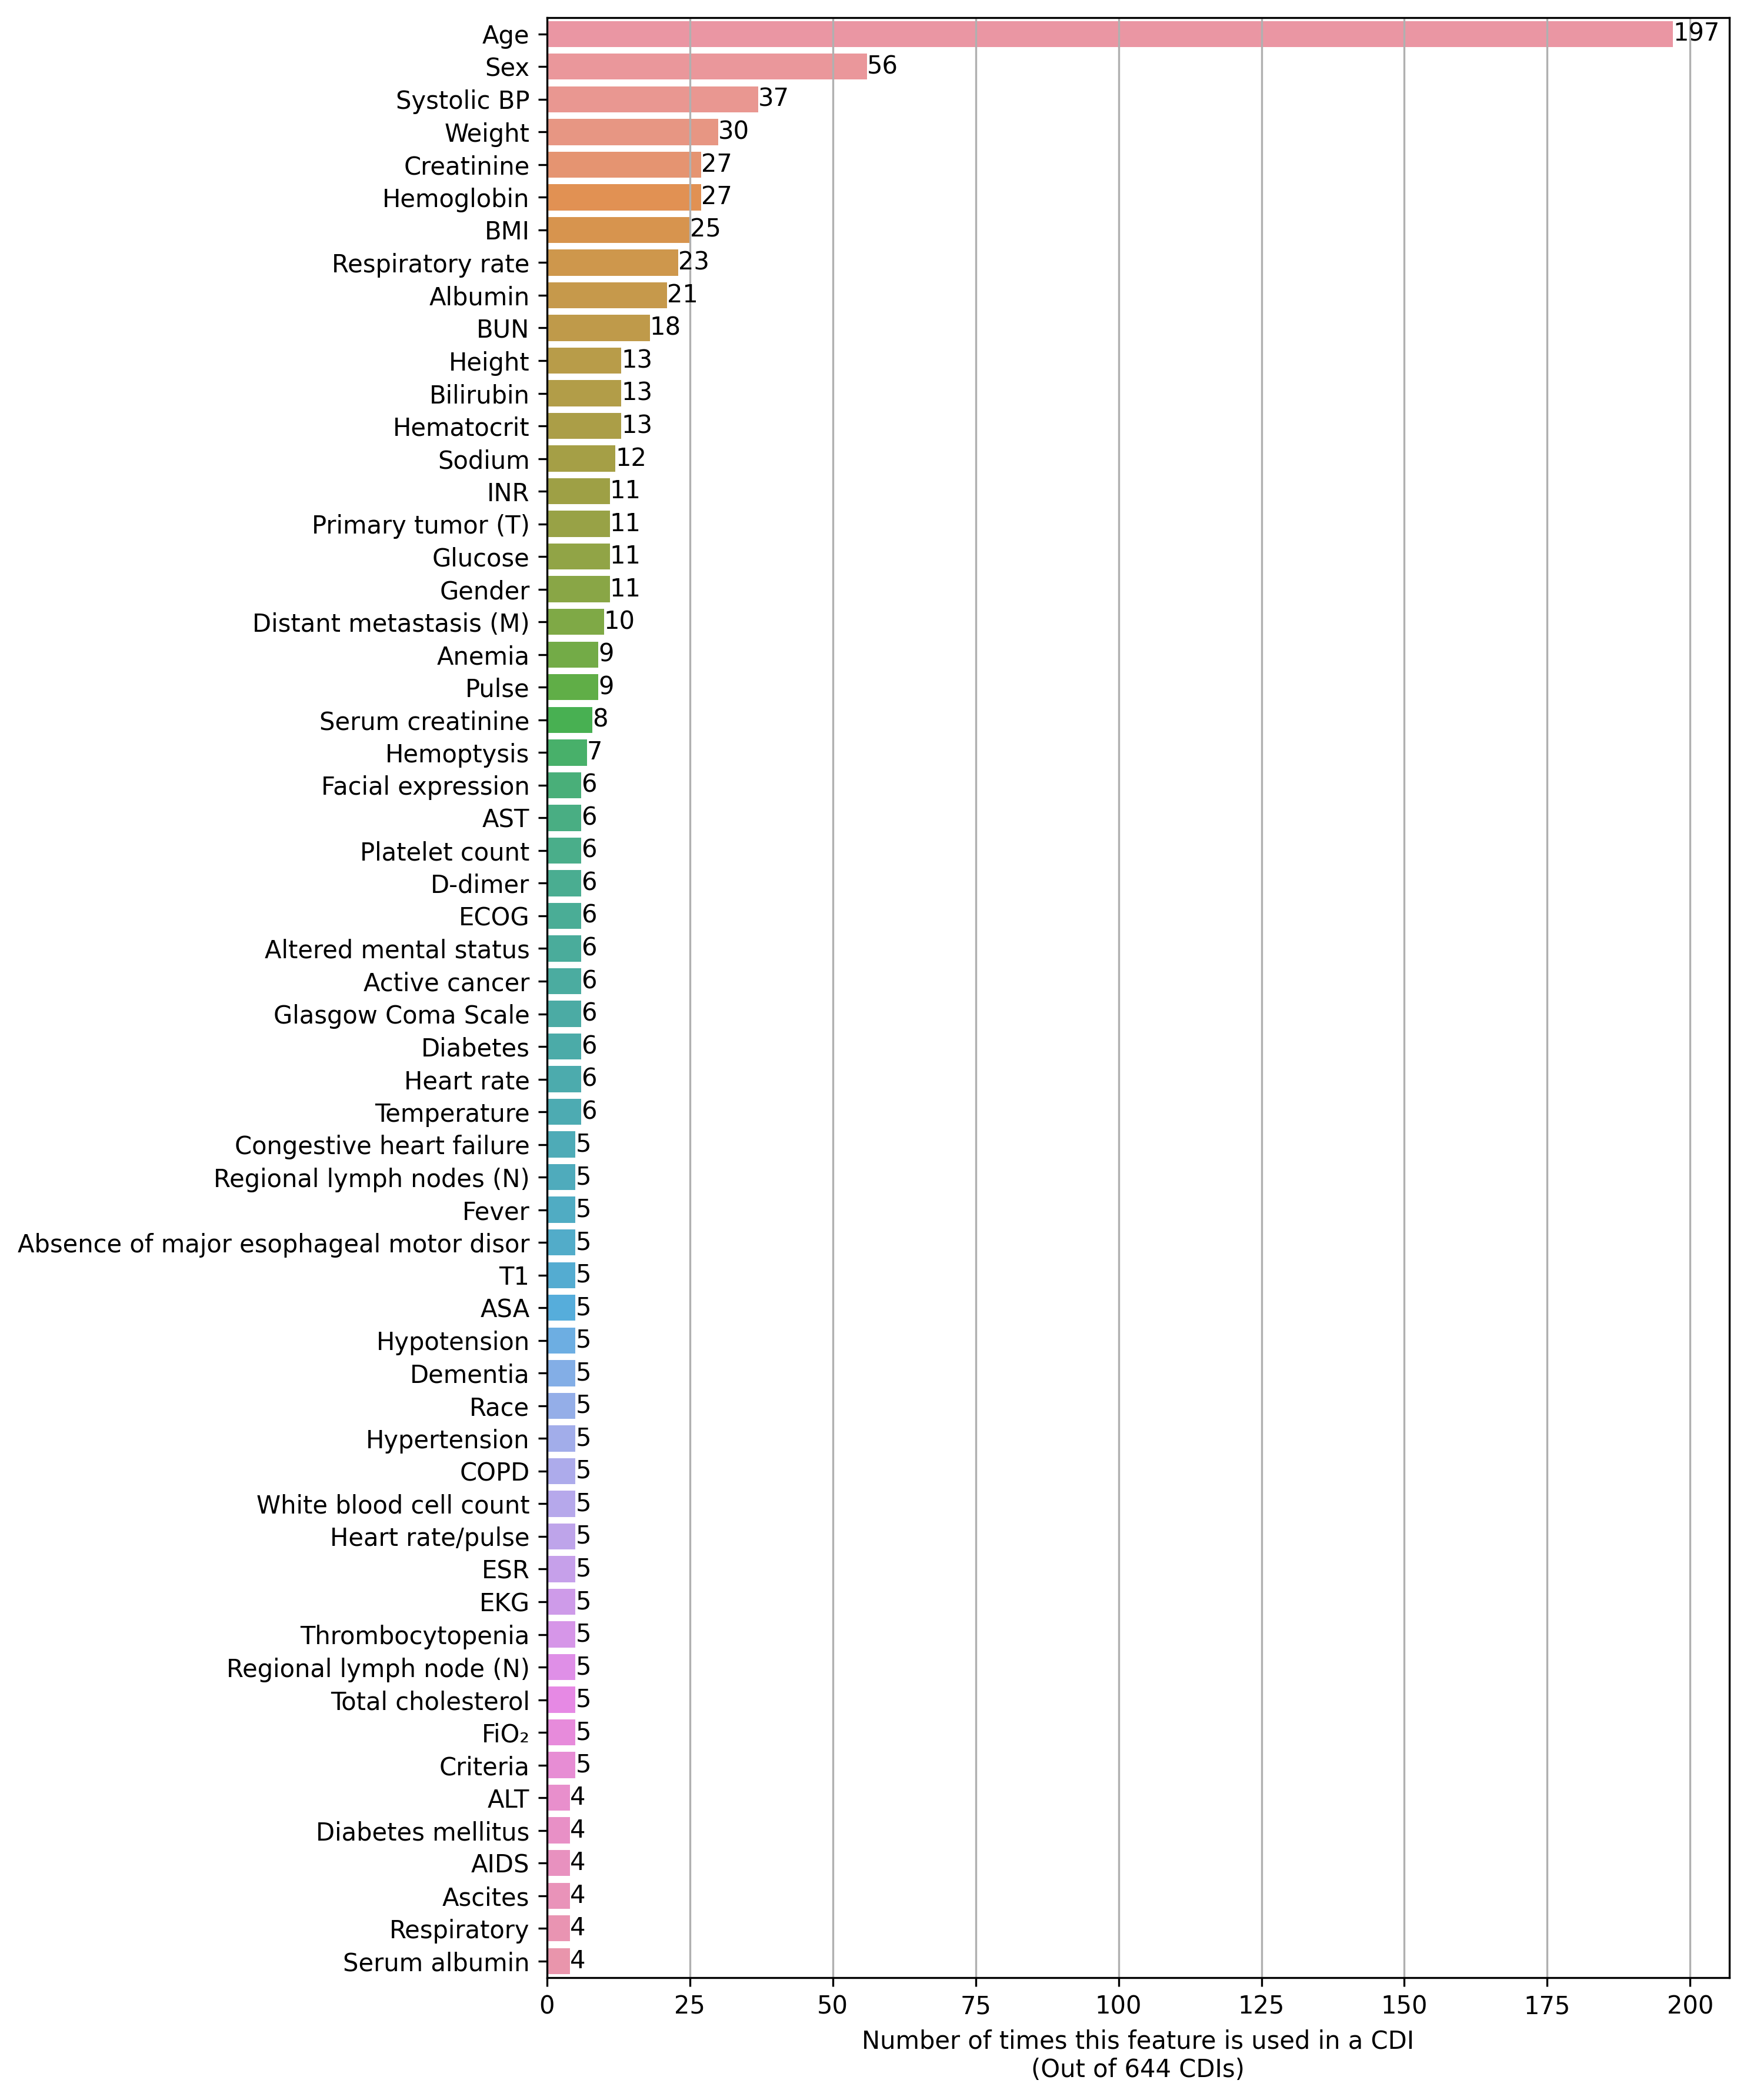

In [209]:
plt.figure(figsize=(10, 12), dpi=300, facecolor='w')
N = 60
plt.grid()
ax = sns.barplot(y=feat_names[:N],
            x=counts.values[:N], orient='h')
ax.bar_label(ax.containers[0])
plt.xlabel(f'Number of times this feature is used in a CDI\n(Out of {df.shape[0]} CDIs)')
plt.tight_layout()
plt.savefig('results/common_features.png')